In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# plot style
mpl.rcParams['font.family'] = 'Segoe UI'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titlepad'] = 4
mpl.rcParams['axes.titleweight'] = 400

# dark mode
mpl.rcParams['figure.facecolor'] = '#1e1e1e'
mpl.rcParams['axes.facecolor'] = '#1e1e1e'
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['axes.titlecolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
mpl.rcParams['text.color'] = 'white'

# dpi and figsize
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%matplotlib inline

FROM_API = True

## Wczytywanie danych z API

Jeśli korzystasz z `FROM_API=True`, pamiętaj o ustawieniu zmiennej środowiskowej HARDCOVER_API_KEY.

In [ ]:
if FROM_API:
    import requests, os
    from collections import defaultdict
    from dotenv import load_dotenv
    load_dotenv()
    url = 'https://api.hardcover.app/v1/graphql'
    headers = {
        'Authorization': 'Bearer ' + os.getenv('HARDCOVER_API_KEY'),
        'Content-Type': 'application/json'
    }

    # Books with more than 10 ratings and more than 3 tags
    query = lambda x: """
      query Books {
        books(
          where: {
            ratings_count: {_gt: 10},
            taggings_aggregate: {
              count: {predicate: {_gt: 3}}
            }
          }
          limit: 100
          offset: """+str(x*100)+"""
        ) {
          id
          title
          description
          rating
          ratings_count
          ratings_distribution
          release_year
          pages
          users_count
          reviews_count
          editions_count
          lists_count
          journals_count
          taggings {
            tag {
              tag
              tag_category {
                category
              }
            }
          }
        }
      }
      """
    books = []
    for i in range(10):
        res = requests.post(url, headers=headers, json={'query': query(i)})
        books += res.json().get("data", {}).get("books", [])
    
    for book in books:
        # Ratings
        ratings = book.get("ratings_distribution", {})
        book["ratings"] = {r['rating']: r['count'] for r in ratings}
        del book["ratings_distribution"]

        # Categories
        categories = defaultdict(list)
        for tagging in book.get("taggings", []):
            tag = tagging["tag"]["tag"]
            category = tagging["tag"]["tag_category"]["category"]
            categories[category].append(tag)
        book.update(categories)
        del book["taggings"]
    pd.DataFrame(books).convert_dtypes().set_index('id').to_csv('books.csv')
data = pd.read_csv('books.csv').convert_dtypes().set_index('id')
eval_cols = ['ratings', 'Genre', 'Mood', 'Pace', 'Tag', 'Content Warning', 'Member']
data[eval_cols] = data[eval_cols].fillna('[]').map(eval)
data

,title,description,rating,ratings_count,release_year,pages,users_count,reviews_count,editions_count,lists_count,journals_count,ratings,Mood,Pace,Tag,Genre,Content Warning,Member
id,,,,,,,,,,,,,,,,,,
880900,The Exchange: After The Firm,#1 NEW YORK TIMES BESTSELLER • John Grisham de...,3.178571,14,2023,353,48,0,2,10,50,"{1.0: 1, 2.0: 2, 3.0: 4, 3.5: 3, 4.0: 3, 5.0: 1}","[Adventurous, dark, emotional, mysterious, ten...","[medium, slow]","[Plot driven, Weak Character Development, Plot...","[Fiction, Adventure]",[],[]
512100,Such Sharp Teeth,A young woman in need of a transformation find...,3.829545,44,2022,337,146,11,4,51,143,"{1.0: 1, 2.0: 3, 2.5: 1, 3.0: 8, 4.0: 19, 4.5:...","[dark, emotional, reflective, challenging, dar...","[fast, medium, fast, fast, medium, fast]","[A mix driven, Strong Character Development, L...","[Fiction, Fantasy, Horror, Cozy, Paranormal, a...","[body horror, Pedophilia, child abuse]",[]
475334,Surrounded by Idiots,Do you ever think you're the only one making a...,3.1875,24,2014,304,83,3,4,16,84,"{1.0: 1, 2.0: 4, 3.0: 10, 3.5: 1, 4.0: 6, 5.0: 2}","[informative, reflective, inspiring]",[medium],[],[Psychology],[],[]
432714,The Perfect Family,Thomas and Viv Adler are the envy of their nei...,3.571429,14,2021,<NA>,47,3,3,25,50,"{2.0: 1, 3.0: 7, 3.5: 1, 4.0: 1, 4.5: 1, 5.0: 3}","[dark, mysterious, reflective, tense, dark, my...","[fast, fast, medium]","[Plot driven, Strong Character Development, Lo...",[Fiction],[],[]
442938,Tyll,FINALISTA DEL PREMIO MAN BOOKER INTERNACIONAL ...,3.807692,13,2017,364,57,1,10,15,59,"{1.0: 1, 2.0: 1, 3.0: 1, 4.0: 6, 4.5: 1, 5.0: 3}","[Adventurous, challenging, funny, reflective]",[medium],"[A mix driven, Weak Character Development, Unl...","[Fantasy, War, Adventure, Fiction]",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512068,The Marriage Portrait,"Florence, the 1550s. Lucrezia, third daughter ...",4.069231,65,2022,361,253,8,12,81,247,"{2.0: 4, 3.0: 9, 3.5: 1, 4.0: 28, 4.5: 2, 5.0:...","[dark, tense, dark, mysterious, sad, Adventuro...","[fast, slow, medium, slow]","[A mix driven, Weak Character Development, Lov...","[Historical Fiction, Renaissance, Fiction, His...",[Rape],[]
432663,Damnation Spring,NATIONAL BESTSELLER Named a Best Book of 2021 ...,3.75,12,2021,464,55,5,4,19,59,"{2.0: 1, 3.0: 3, 4.0: 6, 5.0: 2}","[informative, emotional, challenging]",[slow],"[A mix driven, Weak Character Development, Unl...",[Fiction],[],[]
872028,The Mystery Guest,Molly Gray is not like anyone else. With her f...,3.962264,53,2023,294,158,9,11,47,159,"{2.0: 2, 3.0: 8, 3.5: 4, 4.0: 27, 5.0: 12}","[dark, funny, mysterious, tense, lighthearted,...","[medium, medium]","[series, A mix driven, Strong Character Develo...","[Mystery, Mystery, Crime, Mystery, Fiction]","[Addiction, Alcoholism, bullying, Cursing, dea...",[]


## Wizualizacja danych

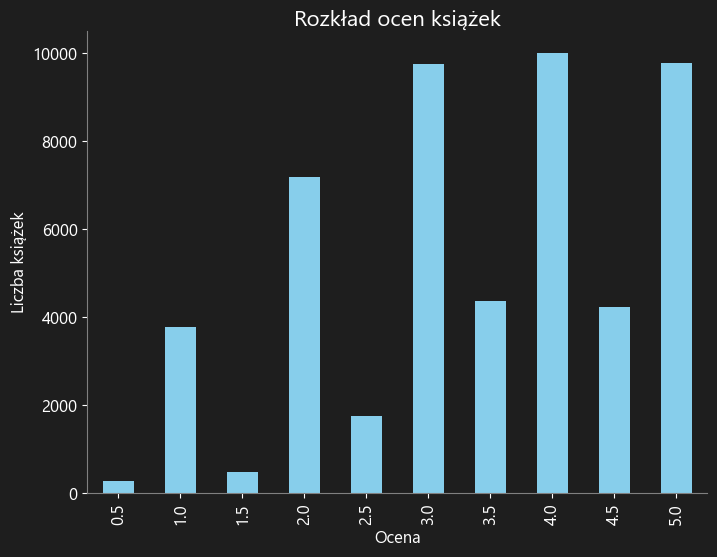

In [ ]:
# Rozkład ocen książek
ratings = data['ratings'].apply(lambda x: x.keys()).explode()
ratings.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Rozkład ocen książek')
plt.xlabel('Ocena')
plt.ylabel('Liczba książek')
plt.show()

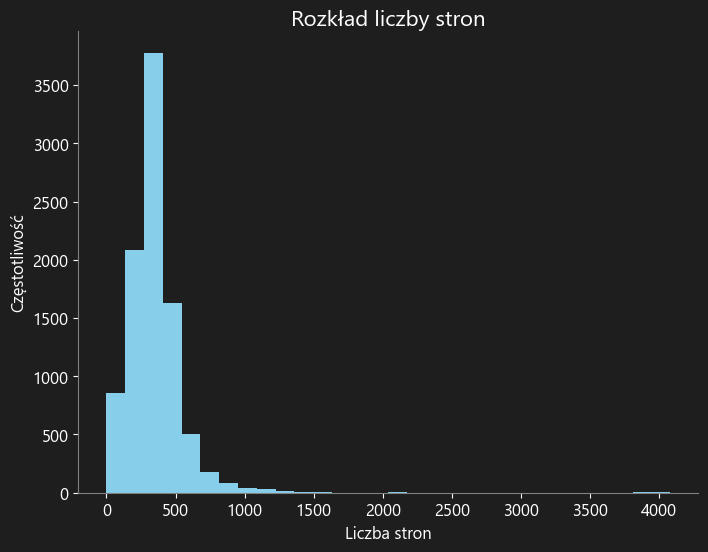

In [ ]:
# Rozkład liczby stron
data['pages'].plot(kind='hist', bins=30, color='skyblue')
plt.title('Rozkład liczby stron')
plt.xlabel('Liczba stron')
plt.ylabel('Częstotliwość')
plt.show()

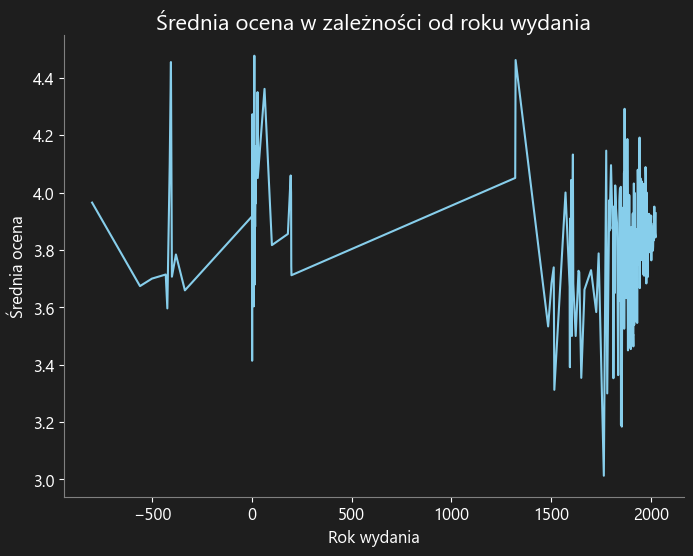

In [ ]:
# Średnia ocena w zależności od roku wydania
avg_rating_by_year = data.groupby('release_year')['rating'].mean()
avg_rating_by_year.plot(kind='line', color='skyblue')
plt.title('Średnia ocena w zależności od roku wydania')
plt.xlabel('Rok wydania')
plt.ylabel('Średnia ocena')
plt.show()

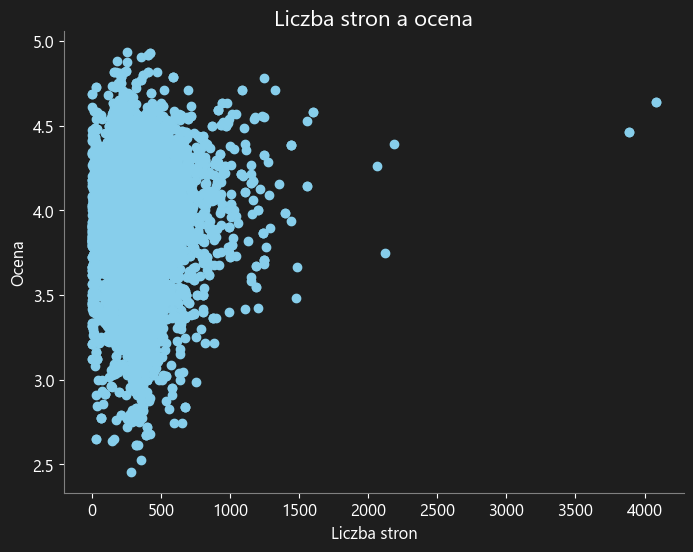

In [ ]:
# Liczba stron a ocena
df = data.dropna(subset=['pages', 'rating'])
plt.scatter(df['pages'], df['rating'], color='skyblue')
plt.title('Liczba stron a ocena')
plt.xlabel('Liczba stron')
plt.ylabel('Ocena')
plt.show()

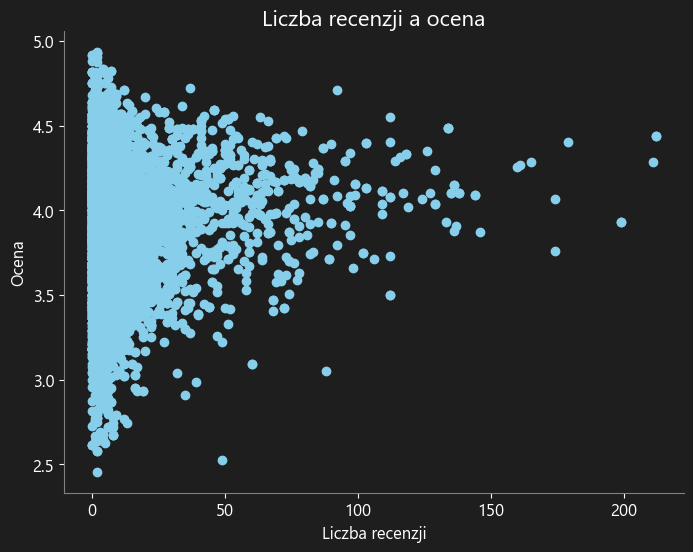

In [ ]:
# Liczba recenzji a ocena
plt.scatter(data['reviews_count'], data['rating'], color='skyblue')
plt.title('Liczba recenzji a ocena')
plt.xlabel('Liczba recenzji')
plt.ylabel('Ocena')
plt.show()

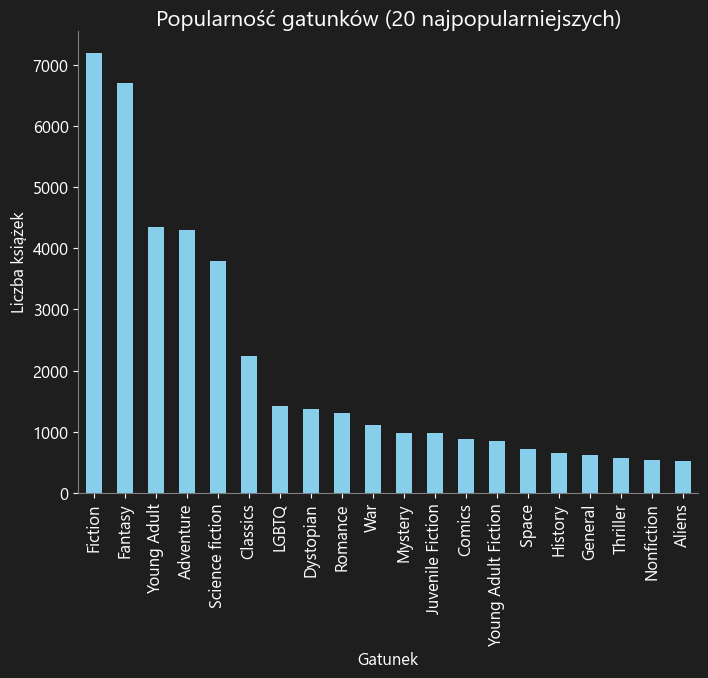

In [ ]:
# Popularność gatunków (20 najpopularniejszych)
genres = data['Genre'].explode()
top_genres = genres.value_counts().nlargest(20)
top_genres.plot(kind='bar', color='skyblue')
plt.title('Popularność gatunków (20 najpopularniejszych)')
plt.xlabel('Gatunek')
plt.ylabel('Liczba książek')
plt.show()

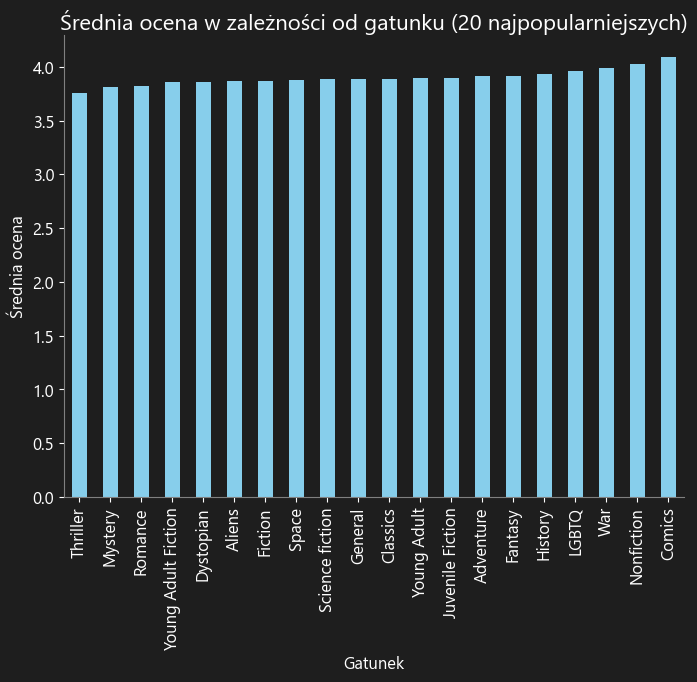

In [ ]:
# Średnia ocena w zależności od gatunku (20 najpopularniejszych)
genres = data['Genre'].explode()
genre_ratings = data.explode('Genre').groupby('Genre')['rating'].mean()
genre_ratings[top_genres.index].sort_values().plot(kind='bar', color='skyblue')
plt.title('Średnia ocena w zależności od gatunku (20 najpopularniejszych)')
plt.xlabel('Gatunek')
plt.ylabel('Średnia ocena')
plt.show()

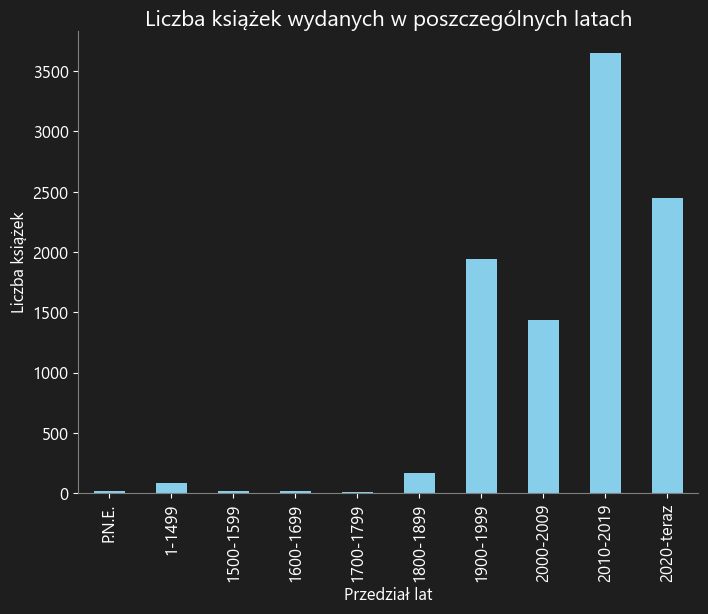

In [ ]:
# Liczba książek wydanych w poszczególnych latach
bins = [-1000, 1, 1500, 1600, 1700, 1800, 1900, 2000, 2010, 2020, 3000]
labels = ['P.N.E.', '1-1499', '1500-1599', '1600-1699', '1700-1799', '1800-1899', '1900-1999', '2000-2009', '2010-2019', '2020-teraz']
data['year_bins'] = pd.cut(data['release_year'], bins=bins, labels=labels, right=False)
books_per_year_bin = data['year_bins'].value_counts().sort_index()
books_per_year_bin.plot(kind='bar', color='skyblue')
plt.title('Liczba książek wydanych w poszczególnych latach')
plt.xlabel('Przedział lat')
plt.ylabel('Liczba książek')
plt.show()

## Predykcja z użyciem modelu Gradient Boosting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Preprocessing
df = data[['rating', 'release_year', 'pages', 'editions_count', 'lists_count', 'journals_count', 'reviews_count', 'Genre', 'ratings']].dropna()
df = df[df['Genre'].isin(top_genres.index)]
print(df.shape)

mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df["Genre"]), columns=mlb.classes_, index=df.index))

def extract_rating_stats(ratings):
    counts = list(ratings.values())
    weighted_sum = sum(k * v for k, v in ratings.items())
    mean = weighted_sum / sum(counts)
    return pd.Series([mean, max(counts), min(counts)])
df[['rating_mean', 'rating_max', 'rating_min']] = df['ratings'].apply(extract_rating_stats)
df.drop(['ratings', 'Genre'], axis=1, inplace=True)

# Normalize numeric columns
scaler = StandardScaler()
numeric_cols = ['release_year', 'pages', 'editions_count', 'lists_count', 'journals_count', 'reviews_count']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Split data
X = df.drop('rating', axis=1)
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)

# Model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))

(9204, 9)
MSE: 1.095807641964585e-05


In [ ]:
df = data[['rating', 'release_year', 'pages', 'editions_count', 'lists_count', 'journals_count', 'reviews_count', 'Genre', 'ratings']].dropna()
def dropRareGenres(genreList):
    return list(set(genreList).intersection(top_genres.index))
df['Genre'] = df['Genre'].apply(dropRareGenres)
print(df.shape)
df.head()

(9204, 9)


,rating,release_year,pages,editions_count,lists_count,journals_count,reviews_count,Genre,ratings
id,,,,,,,,,
465437,4.411765,2019,304,3,22,51,3,[],"{3.0: 2, 4.0: 6, 5.0: 9}"
728081,3.916667,2023,298,3,24,79,3,[Fiction],"{3.0: 3, 4.0: 7, 5.0: 2}"
1126255,4.416667,2023,185,2,1,13,0,[Fiction],"{3.5: 1, 4.0: 5, 4.5: 1, 5.0: 5}"
436615,4.1875,2010,128,2,20,0,2,"[Young Adult, Fantasy]","{2.0: 1, 3.0: 2, 4.0: 6, 5.0: 7}"
793766,4.6875,2016,0,2,28,40,1,[],"{3.5: 1, 4.0: 3, 4.5: 1, 5.0: 11}"


In [ ]:
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df["Genre"]), columns=mlb.classes_, index=df.index))
df.head()

,rating,release_year,pages,editions_count,lists_count,journals_count,reviews_count,Genre,ratings,Adventure,...,LGBTQ,Mystery,Nonfiction,Romance,Science fiction,Space,Thriller,War,Young Adult,Young Adult Fiction
id,,,,,,,,,,,,,,,,,,,,,
465437,4.411765,2019,304,3,22,51,3,[],"{3.0: 2, 4.0: 6, 5.0: 9}",0,...,0,0,0,0,0,0,0,0,0,0
465437,4.411765,2019,304,3,22,51,3,[],"{3.0: 2, 4.0: 6, 5.0: 9}",0,...,0,0,0,0,0,0,0,0,0,0
728081,3.916667,2023,298,3,24,79,3,[Fiction],"{3.0: 3, 4.0: 7, 5.0: 2}",0,...,0,0,0,0,0,0,0,0,0,0
728081,3.916667,2023,298,3,24,79,3,[Fiction],"{3.0: 3, 4.0: 7, 5.0: 2}",0,...,0,0,0,0,0,0,0,0,0,0
1126255,4.416667,2023,185,2,1,13,0,[Fiction],"{3.5: 1, 4.0: 5, 4.5: 1, 5.0: 5}",0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def extract_rating_stats(ratings):
    counts = list(ratings.values())
    weighted_sum = sum(k * v for k, v in ratings.items())
    mean = weighted_sum / sum(counts)
    return pd.Series([mean, max(counts), min(counts)])
df[['rating_mean', 'rating_max', 'rating_min']] = df['ratings'].apply(extract_rating_stats)
df.drop(['ratings', 'Genre'], axis=1, inplace=True)
df.head()

,rating,release_year,pages,editions_count,lists_count,journals_count,reviews_count,Adventure,Aliens,Classics,...,Romance,Science fiction,Space,Thriller,War,Young Adult,Young Adult Fiction,rating_mean,rating_max,rating_min
id,,,,,,,,,,,,,,,,,,,,,
465437,4.411765,2019,304,3,22,51,3,0,0,0,...,0,0,0,0,0,0,0,4.411765,9.0,2.0
465437,4.411765,2019,304,3,22,51,3,0,0,0,...,0,0,0,0,0,0,0,4.411765,9.0,2.0
728081,3.916667,2023,298,3,24,79,3,0,0,0,...,0,0,0,0,0,0,0,3.916667,7.0,2.0
728081,3.916667,2023,298,3,24,79,3,0,0,0,...,0,0,0,0,0,0,0,3.916667,7.0,2.0
1126255,4.416667,2023,185,2,1,13,0,0,0,0,...,0,0,0,0,0,0,0,4.416667,5.0,1.0


In [ ]:
# Split data
X = df.drop('rating', axis=1)
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)

In [ ]:
X.head()

,release_year,pages,editions_count,lists_count,journals_count,reviews_count,1485?-1540,1619-1655--DRAMA.,1775-1817. Sense and sensibility,1800-1815,...,tech development,teen,witches,ya contemporaries,ya romances,ya thrillers,zombies,rating_mean,rating_max,rating_min
id,,,,,,,,,,,,,,,,,,,,,
465437,2019,304,3,22,51,3,0,0,0,0,...,0,0,0,0,0,0,0,4.411765,9.0,2.0
465437,2019,304,3,22,51,3,0,0,0,0,...,0,0,0,0,0,0,0,4.411765,9.0,2.0
728081,2023,298,3,24,79,3,0,0,0,0,...,0,0,0,0,0,0,0,3.916667,7.0,2.0
728081,2023,298,3,24,79,3,0,0,0,0,...,0,0,0,0,0,0,0,3.916667,7.0,2.0
1126255,2023,185,2,1,13,0,0,0,0,0,...,0,0,0,0,0,0,0,4.416667,5.0,1.0


In [ ]:
y.head()

id
465437     4.411765
465437     4.411765
728081     3.916667
728081     3.916667
1126255    4.416667
Name: rating, dtype: Float64

In [ ]:
'Fiction' in top_genres.index

True